In [1]:
import numpy as np
import tensorflow as tf
import gpflow
import matplotlib.pyplot as plt

tf.keras.backend.set_floatx('float64')


def generate_sample(
    n_points: int = 500,
    sigma_n: float = 0.5,
    percent_output_outliers: float = 0.0,
    add_input_outliers: bool = False,
    n_input_outliers: int = 10,
    input_outlier_spread: float = 20.0,
    seed: int = 10,
    plot: bool = True
) -> tuple[np.ndarray, np.ndarray, np.ndarray, gpflow.kernels.Kernel]:
    """
    Generate GP sample with optional input/output outliers.

    Returns:
        X (np.ndarray): full original input grid.
        y_obs (np.ndarray): observations (with noise and outliers if enabled).
        f (np.ndarray): true underlying function (noiseless).
        kernel (gpflow.kernels.Kernel): kernel used to generate the data.
    """
    # Set seed
    np.random.seed(seed)
    tf.random.set_seed(seed)

    # Kernel
    kernel = gpflow.kernels.SquaredExponential(lengthscales=1.0, variance=1.0)

    # Original input and function
    x = np.linspace(0, 20, n_points).reshape(-1, 1)
    f = np.random.multivariate_normal(
        mean=np.zeros(n_points),
        cov=kernel(x, x) + 1e-8 * np.eye(n_points)
    ).reshape(-1, 1)
    y_obs = f + np.random.normal(scale=sigma_n, size=(n_points, 1))

    # Apply output outliers
    if percent_output_outliers > 0:
        i_mis = np.random.choice(n_points, int(percent_output_outliers * n_points), replace=False)

        upp = 2
        low = 1

        pos_mask = (y_obs[i_mis] > 0).flatten()
        neg_mask = ~pos_mask

        y_obs[i_mis[pos_mask]] += np.random.uniform(low, upp, size=(pos_mask.sum(), 1))
        y_obs[i_mis[neg_mask]] -= np.random.uniform(low, upp, size=(neg_mask.sum(), 1))

    # Apply input outliers
    if add_input_outliers and n_input_outliers > 0:
        x_min, x_max = x.min(), x.max()

        x_outliers_low = np.random.uniform(
            low=x_min - input_outlier_spread,
            high=x_min - 0.1 * input_outlier_spread,
            size=(n_input_outliers // 2, 1)
        )
        x_outliers_high = np.random.uniform(
            low=x_max + 0.1 * input_outlier_spread,
            high=x_max + input_outlier_spread,
            size=(n_input_outliers - x_outliers_low.shape[0], 1)
        )
        x_outliers = np.vstack([x_outliers_low, x_outliers_high])

        K_xo = kernel(x_outliers, x_outliers) + sigma_n**2 * np.eye(n_input_outliers)
        y_outliers = np.random.multivariate_normal(
            mean=np.zeros(n_input_outliers),
            cov=K_xo
        ).reshape(-1, 1)

        x_obs = np.vstack([x, x_outliers])
        y_obs = np.vstack([y_obs, y_outliers])
        order = np.argsort(x_obs[:, 0])
        x_obs, y_obs = x_obs[order], y_obs[order]
    else:
        x_obs = x

    # Optional plotting
    if plot:
        plt.figure(figsize=(10, 5))
        plt.plot(x, f, 'k--', lw=2, label='true f(x)')
        plt.plot(x_obs, y_obs, 'r.', ms=8, alpha=0.7, label='observed data')
        plt.legend()
        x_min = x.min()
        x_max = x.max()
        plt.xlim(x_min - input_outlier_spread, x_max + input_outlier_spread)
        plt.title("Generated GP Sample with Outliers")
        plt.show()

    return x, y_obs, f, kernel


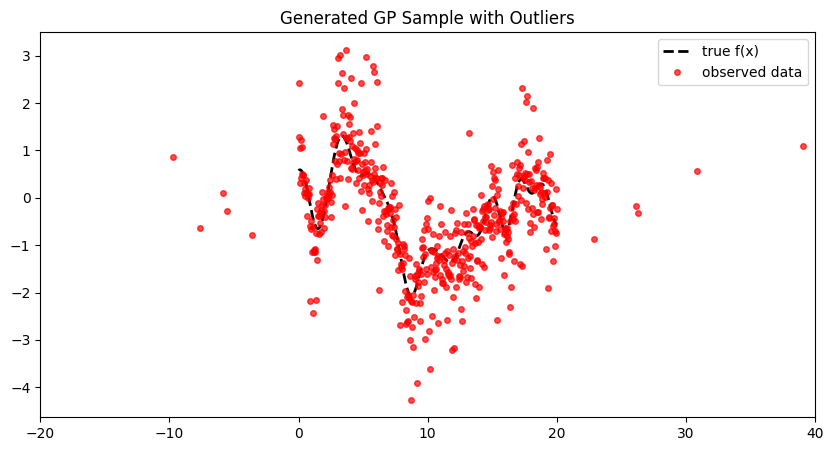

(array([[ 0.        ],
        [ 0.04008016],
        [ 0.08016032],
        [ 0.12024048],
        [ 0.16032064],
        [ 0.2004008 ],
        [ 0.24048096],
        [ 0.28056112],
        [ 0.32064128],
        [ 0.36072144],
        [ 0.4008016 ],
        [ 0.44088176],
        [ 0.48096192],
        [ 0.52104208],
        [ 0.56112224],
        [ 0.6012024 ],
        [ 0.64128257],
        [ 0.68136273],
        [ 0.72144289],
        [ 0.76152305],
        [ 0.80160321],
        [ 0.84168337],
        [ 0.88176353],
        [ 0.92184369],
        [ 0.96192385],
        [ 1.00200401],
        [ 1.04208417],
        [ 1.08216433],
        [ 1.12224449],
        [ 1.16232465],
        [ 1.20240481],
        [ 1.24248497],
        [ 1.28256513],
        [ 1.32264529],
        [ 1.36272545],
        [ 1.40280561],
        [ 1.44288577],
        [ 1.48296593],
        [ 1.52304609],
        [ 1.56312625],
        [ 1.60320641],
        [ 1.64328657],
        [ 1.68336673],
        [ 1

In [2]:
generate_sample()

We first do with no outliers

In [4]:
#from models import ---


seeds=[1,2,3,4,5]
perf_GP=[]
perf_GVI_alpha_cf=[]
perf_GVI_induc=[]
perf_SGP=[]
perf_SGPa=[]


cases=[[0.0,False],[0.1,False],[0.0,True][0.1,True]]

for perc,input_o in cases:
    for seed in seeds:
        x, y_obs, f, kernel = generate_sample(seed=seed,plot=False,add_input_outliers=input_o,percent_output_outliers=perc)
        
        #test gp
        
        #test GVI_GP
        
        #test GVI_GP_ind
        
        #test SGP
        
        #test SVGP
        
        
        #test SGPa
        
        
        #test SVGPa
        
    
    